In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import emcee
import corner

In [2]:
data = Table.read("pleiadi_817", format= "ascii" )

In [3]:
#data

In [4]:
pmRA = data["pmRA"]
pmDE = data["pmDE"]
RA = data["RArad"]
DE = data["DErad"]
Plx = data["Plx"]
e_plx = data["e_Plx"]

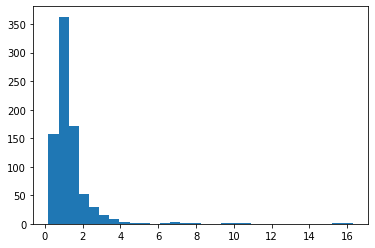

In [5]:
plt.hist(e_plx, bins = 30);
#plt.plot

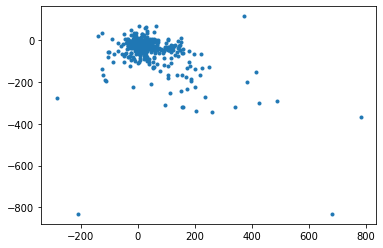

In [6]:
plt.plot(pmRA, pmDE, '.')

(-60.0, 20.0)

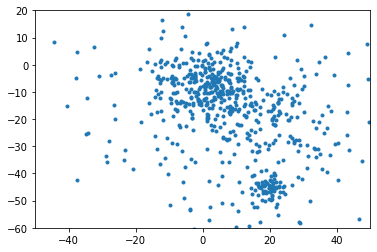

In [7]:
plt.plot(pmRA, pmDE, '.')
plt.xlim(-50,50)
plt.ylim(-60,20)

In [8]:
def sum_err(e_plx, sigma_cl):
    return sigma_cl**2 + e_plx**2

def Uniform(Plx):
    for i in range(len(Plx)):
        if( Plx[i] > 0 or Plx[i] < 10):
            return 1./(10)
        else:
            return 0

'''def loglikelihood(par, Plx, e_plx):
    Pcl, sigma_cl, f = par
    err = sum_err(e_plx, sigma_cl)
    return np.sum(np.logaddexp( (- 0.5 * (np.log(2*np.pi) + np.log(err) + (Plx - Pcl)**2/(err))) + np.log(f), np.log(1-f)+np.log(np.random.uniform(4,12))))
    '''
def loglikelihood(par, Plx, e_Plx) :
    Pcl, sigma_cl, f = par
    err = sum_err(e_Plx, sigma_cl)
    return np.sum(np.logaddexp(np.log(f) - 0.5*(np.log(2) + np.log(np.pi) + np.log(err)) - 0.5*(Plx - Pcl)**2 / (err), np.log(1 - f) + np.log(1./999)))
    
    

In [9]:
Pcl_min = 1
Pcl_max = 1000
sigma_cl_min = 0
sigma_cl_max = 10
f_min = 0.0001
f_max = 1

def logprior(par):
    Pcl, sigma_cl, f = par
    if Pcl < Pcl_min or Pcl > Pcl_max or sigma_cl < sigma_cl_min or sigma_cl > sigma_cl_max or f < f_min or f> f_max:
        return -np.inf
    else:
        return -np.log((Pcl_max - Pcl_min)*(sigma_cl_max - sigma_cl_min)*(f_max- f_min))

In [10]:
def logposterior(par, Plx, e_plx):
    lp = logprior(par)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglikelihood(par, Plx, e_plx)

In [11]:
Y = np.zeros((len(pmRA), 2))

for i in range(len(pmRA)):
    Y[i,0] = pmRA[i]
    Y[i,1] = pmDE[i]

In [12]:
#gm.means_

(-100.0, 100.0)

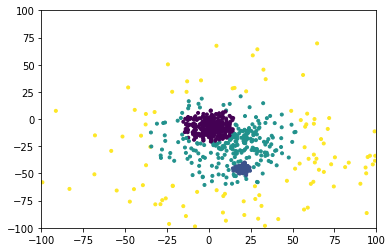

In [13]:
gm = GaussianMixture(n_components=5, random_state=0, n_init=100, 
                     init_params="random", covariance_type = 'spherical').fit(Y)
labels = gm.predict(Y)
plt.scatter(Y[:,0], Y[:,1], c = labels, marker = '.')
plt.xlim(-100,100)
plt.ylim(-100,100)

In [14]:
data['prob'] = gm.predict_proba(Y)

In [15]:
#data[data['prob'] ]

In [16]:
#metodo 1 per tagliare i dati
prob = data['prob']
p = prob[:,1]
mask = [(p > 0.10)]

Plxs= Plx[tuple(mask)]
e_plxs = e_plx[tuple(mask)]

In [17]:
len(Plxs)

78

In [18]:
Plxs;

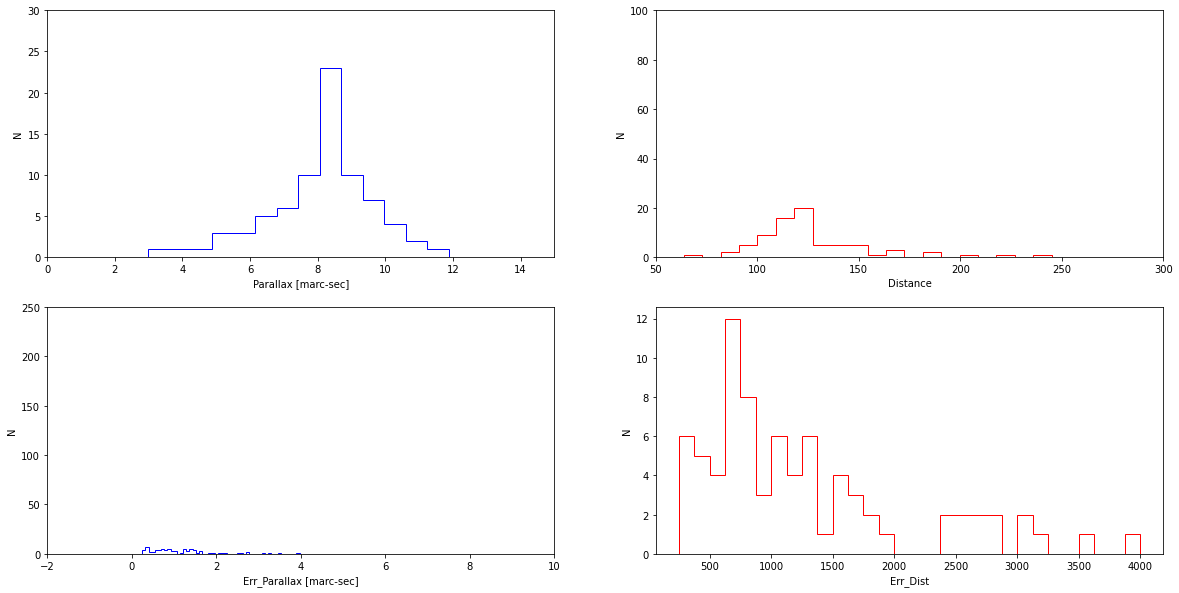

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(20,10));
axs[0,0].hist(Plxs, bins = 20, histtype='step', color = 'blue');
axs[0,0].set_xlim(0, 15)
axs[0,0].set_ylim(0, 30)
axs[0,0].set_xlabel("Parallax [marc-sec]")
axs[0,0].set_ylabel("N");
axs[0,1].hist(1000/Plxs, bins = 30, histtype='step', color = 'red');
axs[0,1].set_xlim(50, 300)
axs[0,1].set_ylim(0, 100)
axs[0,1].set_xlabel("Distance")
axs[0,1].set_ylabel("N");
axs[1,0].hist(e_plxs, bins = 50, histtype='step', color = 'blue');
axs[1,0].set_xlim(-2, 10)
axs[1,0].set_ylim(0, 250)
axs[1,0].set_xlabel("Err_Parallax [marc-sec]")
axs[1,0].set_ylabel("N");
axs[1,1].hist(1000/e_plxs, bins = 30, histtype='step', color = 'red');
axs[1,1].set_xlabel("Err_Dist")
axs[1,1].set_ylabel("N");

(-60.0, -30.0)

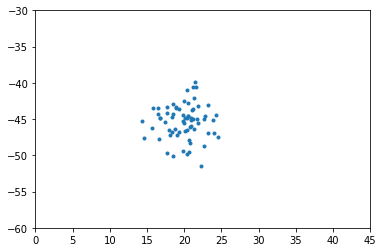

In [20]:
#metodo 2 per tagliare i dati
ppmDE = []
ppmRA = []
pDE = []
pRA = []
pPlx = []
pe_plx = []

for i in range(len(labels)):
    if (labels[i] == 1):
        ppmDE.append(pmDE[i])
        ppmRA.append(pmRA[i])
        pDE.append(DE[i])
        pRA.append(RA[i])
        pPlx.append(Plx[i])
        pe_plx.append(e_plx[i])
        
fig, ax = plt.subplots()
ax.plot(ppmRA, ppmDE, '.')
ax.set_xlim(0,45)
ax.set_ylim(-60,-30)

In [21]:
sigma_cl = gm.covariances_[1]
print(sigma_cl)

6.0794516207080305


In [22]:
pPlx_ = np.array(pPlx)
pe_plx_ = np.array(pe_plx)

In [23]:
Uniform(pPlx)

0.1

In [24]:
soln = [np.random.uniform (Pcl_min, Pcl_max), np.random.uniform(sigma_cl_min, sigma_cl_max), np.random.uniform(f_min, f_max)]
print(soln)
pos = soln + 1e-4 * np.random.randn(7, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(Plxs, e_plxs))

sampler.run_mcmc(pos, 5000, progress=True);

[614.2815273051675, 6.388814416887854, 0.49146877346190637]


100%|██████████| 5000/5000 [00:16<00:00, 310.18it/s]


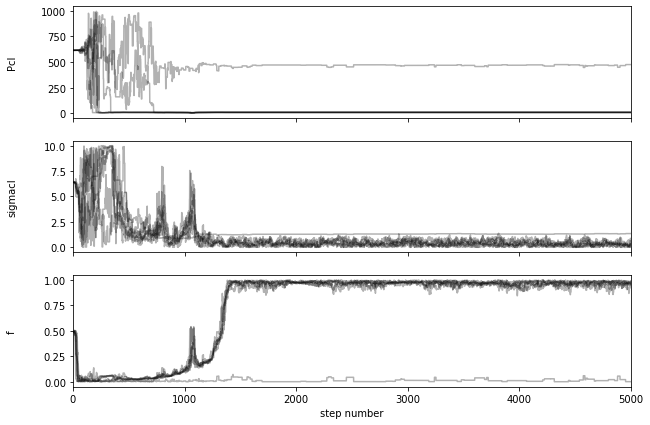

In [25]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl", 'f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [26]:
samples[4999,3,0], samples[4999,3,1], samples[4999,3,2]

(8.25071659160614, 0.24810926836052416, 0.9576895547470033)

In [27]:
soln = [samples[4999,3,0], samples[4999,3,1], samples[4999,3,2]]
pos = soln + 1e-4 * np.random.randn(7, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(Plxs, e_plxs))

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:33<00:00, 297.71it/s]


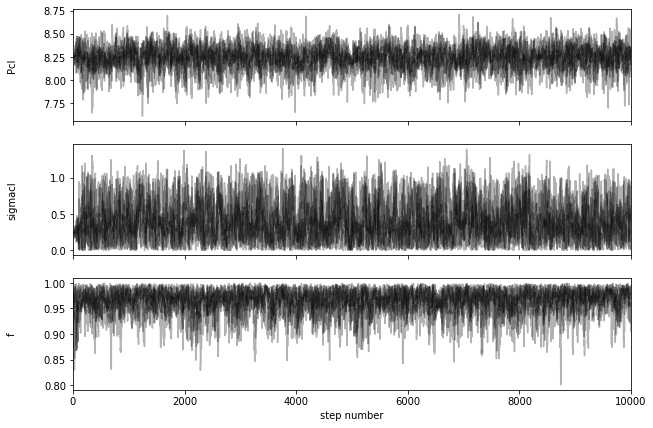

In [28]:
fig1, axes1 = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl", 'f']
for i in range(ndim):
    ax1 = axes1[i]
    ax1.plot(samples[:, :, i], "k", alpha=0.3)
    ax1.set_xlim(0, len(samples))
    ax1.set_ylabel(labels[i])
    ax1.yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel("step number");

In [29]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples.shape)

(69300, 3)


In [30]:
flat_samples[:,1]

array([0.40529886, 0.32520188, 0.3165173 , ..., 0.24867544, 0.74547203,
       0.06315402])

SONO IN UNITà DI MISURA IN PARALLASSE. PER TRASFORMARLI IN PARSEC DEVO:
PER LE DISTANZE 

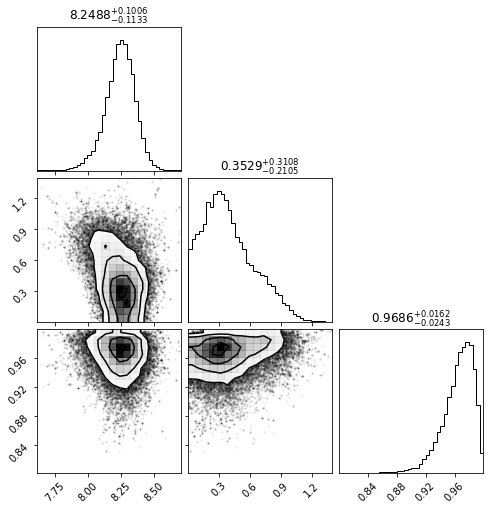

In [31]:
labels = ['Pcl', 'sigma_cl', 'f']
fig = corner.corner(flat_samples, show_titles=True, label=labels,  labelpad = 1, title_fmt='.4f', hist_bin_factor = 2);
plt.savefig("posterior.pdf")

In [32]:
flat_samples[:, 1] = (1000.*flat_samples[:, 1])/(flat_samples[:, 0]**2) # propagazione errori
flat_samples[:, 0] = 1000./flat_samples[:,0] 

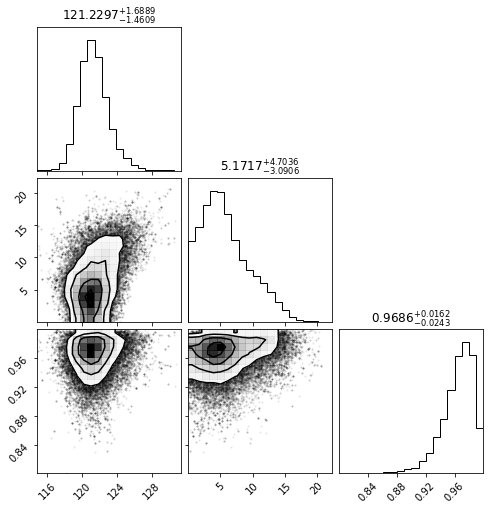

In [33]:
labels = ['Pcl', 'sigma_cl', 'f']
fig = corner.corner(flat_samples, show_titles=True, label=labels,  labelpad = 1, title_fmt='.4f', hist_bin_factor = 1);
plt.savefig("posterior.pdf")

In [44]:
mio = np.array(pPlx)

In [56]:
fine = 1000/mio

In [86]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [87]:
fine1 = selection_sort(fine)

(115.0, 130.0)

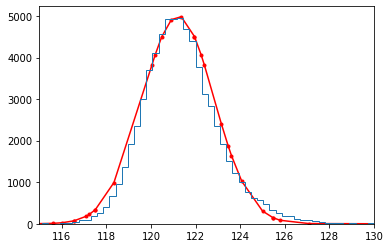

In [89]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.)/ (2 * np.power(sig, 2.)))

plt.plot(fine1, 5000*gaussian(fine1, 121.22, 1.6), marker = '.', color = 'r')
plt.hist(flat_samples[:,0],bins = 60, histtype='step');
plt.xlim(115, 130)

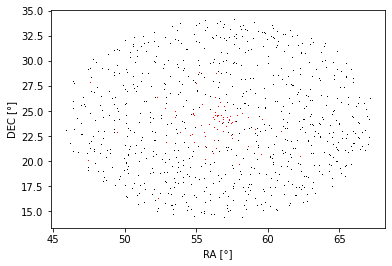

In [35]:
fig, ax = plt.subplots()
#ax.set_facecolor('black')
#ax.plot(RA, DE, ',', c = 'white')
ax.plot(RA, DE, ',', c = 'black')
ax.plot(pRA, pDE, ',', c = 'r')
ax.set_xlabel('RA [°]')
ax.set_ylabel('DEC [°]')
plt.savefig("Rapp.pdf")

In [36]:
Il valore della sigma è debolmente 
inoltre 

SyntaxError: invalid syntax (Temp/ipykernel_8116/2878961373.py, line 1)

In [ ]:
flat_samples[9999,0], flat_samples[9999,1]

In [ ]:
'''#dist = np.zeros(len(flat_samples))
#sigma = np.zeros(len(flat_samples))
b1 = [ [ 0 for i in range(3) ] for j in range(len(flat_samples)) ]
for i in range(len(flat_samples)):
    mine.append(1000/flat_samples[i,0], flat_samples[i,0])
    #dist[i] = 1000/flat_samples[i,0]
    #sigma[]'''

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

for mu, sig in [(flat_samples[9999,0], np.abs(flat_samples[9999,1]))]:
    plt.scatter(Plxs, gaussian(Plxs, mu, sig))

plt.show()

In [ ]:
soln = [samples[4999,3,0], samples[4999,3,1], samples[4999,3,2]]
pos = soln + 1e-4 * np.random.randn(7, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(Plxs, e_plxs))

sampler.run_mcmc(pos, 200, progress=True);
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)

In [ ]:
def gaussian(x, mu, sig, sog):
    return np.exp(-np.power(x - mu, 2.) / (2 * (np.power(sig, 2.) + np.power(sog, 2.))))

#for i in range(len(flat_samples)):
plt.scatter(1000/flat_samples[:,0], gaussian(1000/flat_samples[:,0], 1000/flat_samples[199,0], 1000/((flat_samples[199,0])**2)*np.abs(flat_samples[199,1]), (1000/flat_samples[:,0]**2)*flat_samples[:,1]))

plt.show()

In [ ]:
flat_samples

In [ ]:
plt.scatter(flat_samples[:,0], flat_samples[:,1], marker = '.')